In [40]:
from itertools import combinations
import math
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor

from rshdmrgpr.rs_hdmr_gpr import *

In [2]:
def print_kernel_info(models):
    idx = 1
    for model in models:
        print(f"Component function {idx} optimized kernel: {model.kernel_}")
        idx += 1

This notebook supplements the research paper:  
  
<font color='red'>**Random Sampling High Dimensional Model Representation Gaussian Process Regression (RS-HDMR-GPR) for representing multidimensional functions with machine-learned lower-dimensional terms allowing insight with a general method **</font>
    
The following section contains code used to generate the figures in Sections 3.2.

In [3]:
# Extracts the data set
data = load_data('KED')

C:\Users\owenz\Desktop\PureFacts\rshdmrgpr


In [4]:
data.min()

a1     4.660084e-05
a2     0.000000e+00
a3    -1.792079e-02
a4     0.000000e+00
a5    -1.436699e-03
a6     1.100000e-14
a7    -8.939882e-02
out    7.299957e-04
dtype: float64

In [5]:
# Scales the data set to be between [0, 1]
scale = data['out'].max() - data['out'].min()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns=data.columns)

In [6]:
features = data_scaled.drop(columns=['out'])
labels = data_scaled['out']

In [7]:
data.head()

,a1,a2,a3,a4,a5,a6,a7,out
0,0.000224,0.000000,0.004583,0.000000,0.000000,0.093880,0.011589,0.002946
1,0.000278,0.000403,0.005023,0.000585,0.007290,0.090925,0.012134,0.003776
2,0.000487,0.001494,0.006073,0.004582,0.018629,0.075739,0.013103,0.006063
3,0.001004,0.002777,0.006860,0.007680,0.018973,0.046869,0.012994,0.008953
4,0.002046,0.003409,0.006222,0.005680,0.010368,0.018924,0.008730,0.010948


In [8]:
data.shape

(585890, 8)

##### Helper Functions

In [9]:
def get_RMSE(y, y_pred):
    """Computes the RMSE between two vectors"""
    rmse = math.sqrt(mean_squared_error(y, y_pred))
    print(f'The RMSE is {rmse}')
    return rmse

### HDMR FITS

In this example the noise level is fixed for all component functions and we only optimize the length parameters (as in the article). We only fit the 500 point trainset example due to computational cost.

In [32]:
class RSHDMRGPR:

    def __init__(self, matrices, kernels):
        """
        Initializes an instance of RS-HDMR-GPR object.

        :param matrices: list of 2D numpy.Arrays
            A list of linear transformations.
        :param kernels: a list of Objects from sklearn.guassian_process.kernels
            The kernel to be used for training each HDMR. Right now only RBF and Matern kernels are supported.
        """
        # number of models cannot be empty
        if len(matrices) == 0:
            raise RuntimeError('Must provide at least one component function.')
        if len(matrices) != len(kernels):
            raise RuntimeError(f'Number of affine transformations must be equal to the number of kernels provided'
                               f'which is {len(kernels)}.')

        self.num_rows = matrices[0].shape[0]
        for mat in matrices:
            if mat.shape[0] != self.num_rows:
                raise RuntimeError(f'The rows of the provided matrices are not all the same.')

        self.num_models = len(matrices)
        self.matrices = matrices
        self.kernels = kernels

        self.is_trained = False
        self.models = None
        self.columns = [True] * self.num_models

    @staticmethod
    def verbose_print(msg, end=None, on=True):
        """
        Helper Function used to print messages specified by the user

        :param msg: str
            The message to print
        :param end: str
            Specifies the ending of a line
        :param on: bool
            Specifies whether to print or not
        :return: None
        """
        if on and end is not None:
            print(msg, end=end)
        elif on:
            print(msg)

    def train(self, x_train, y_train, alphas=1e-7, n_restarts=1, cycles=50, scale_down=(0.2, 2), optimizer=None,
              opt_every=5, use_columns=None, initializer='even', report_loss=False, verbose=0, opt_noise=True):
        """
        Trains the RSHDMRGPR model (trains all the GPR sub-models, ie. the component functions).

        :param x_train: pandas DataFrame
            Contains the features.
        :param y_train: list or 1d-array
            The label column of the data.
        :param alphas: float or list of float
            The noise level to be set for the component functions, each of which is a GPR model. If int, the noise
            level for training each of these models is the set to this for all cycles. To set different noise levels for
            different component functions, a list of int must be specified. Note that if optimizer is used, these values
            will be optimized via a WhiteKernel.
        :param scale_down: tuple
            A length 2 tuple containing the starting scale factor and the step size. start represents the starting
            fraction of scale down, and step size represents a rate at which this fraction increases. This is used to
            prevent overfitting of a single component function.
        :param cycles: int
            The number of cycles to train. Must be a positive integer.
        :param optimizer: str or list of str
            Must be a GPR optimizer or list of such. Please see sklearn documentation for GaussianProcessRegressor
            optimizer.
        :param opt_every: int
            Specifies every (opt_every) cycles to apply the optimizer. Default=1 (optimizer applied every cycle). This
            control variable does nothing if the optimizer argument is not provided
        :param use_columns: list of bool or None
            Specifies which column to use (True indicates use, False otherwise). If None (not specified), all columns
            are used.
        :param n_restarts: int
            Positive integer indicating the number of restarts on training. Does nothing meaningful if the optimizer is
            not provided.
        :param initializer: list of float or 'even'
            Initializes the starting targets for each component function. If 'even', every target is initialized as
            y_train / (Number of True in use_columns).
        :param report_loss: bool
            Saves the loss from the prediction on the training set over cycles. Only RMSE (Root mean-squared error) is
            supported for now.
        :param verbose: int
            Sets the various print details option during training. Takes on values 0, 1, or 2. Default is 0.
        :return: Returns 1) if report_rmse = True, 2) otherwise.
            1) self, pandas DataFrame
                The first argument is the trained instance of self. The second contains the RMSE of predicted
                values (vs actual) on the training set for each cycle.
            2) self
                The trained instance of self.
        """

        # Checks if the model has been trained already. Should only train once.
        if self.is_trained:
            raise RuntimeError('Model has already been trained')

        # Validates that the number of features matches the number of rows for each element in self.matrices.
        if x_train.shape[1] != self.num_rows:
            raise RuntimeError(f'Number of columns in provided data which is {x_train.shape[1]} does not match number '
                               f'of rows which is {self.num_rows} in each linear transformation')

        # Validates the noise parameter
        if isinstance(alphas, list):
            if len(alphas) != self.num_models:  # Checks   that number of alphas is equal to the number of models
                raise RuntimeError(f'The length of alphas must match {self.num_models} but received {len(alphas)}')
            for a in alphas:  # Every alpha provided must be an int or float
                if not isinstance(a, (int, float)):
                    raise RuntimeError(f'A non-float value {a} was provided as the noise')
        elif not isinstance(alphas, (int, float)):
            raise RuntimeError('Provided alpha is not a float or list of floats')
        if isinstance(alphas, (int, float)):  # if just a float or int is provided, all noise will be set to this noise
            alphas = [alphas] * self.num_models
        # Adds in the noise parameter (which is WhiteKernel) for each model.
        for i in range(len(self.kernels)):
            self.kernels[i] += WhiteKernel(alphas[i], 'fixed')

        # Validates the scale_down argument
        if scale_down is None:
            start, step = 1, 0  # No scale down in this case
        elif isinstance(scale_down, tuple):
            if len(scale_down) != 2:
                raise RuntimeError(f'scale_down must contain 2 elements but received {len(scale_down)}')
            start, step = scale_down[0], scale_down[1]
        else:
            raise RuntimeError(f'scale_down must be of type {tuple} but received {type(scale_down)}')

        # Validates the optimizer parameter
        if isinstance(optimizer, list):
            if len(optimizer) != self.num_models:
                raise RuntimeError(f'optimizer provided as a list must have length equal to the number of'
                                   f'{self.num_models} but received {len(alphas)}.')
        elif isinstance(optimizer, str):
            optimizer = [optimizer] * self.num_models
        elif optimizer is None:
            optimizer = [optimizer] * self.num_models

        # Decides which component function to use in training
        if use_columns is not None:
            if len(use_columns) == self.num_models and all(isinstance(a, bool) for a in use_columns):
                self.columns = use_columns
            else:
                raise RuntimeError(f"use_columns must be a list of bool of length {self.num_models}.")

        # Initializes the list of models to be trained.
        self.models = [None] * self.num_models

        # Initializes the component outputs used for training.
        if initializer == 'even':
            y_i = [y_train / sum(self.columns)] * self.num_models
            for i in range(self.num_models):
                if not self.columns[i]:
                    y_i[i] = 0
        elif isinstance(initializer, list) and len(initializer) == self.num_models:
            y_i = [initializer[i] * y_train for i in range(self.num_models)]
        else:
            raise RuntimeError(f"Invalid initializer, must be a list of size {self.num_models} or 'even'.")

        # Verbose printing options:
        if verbose not in [0, 1, 2]:
            raise RuntimeError(f'The valid levels of verbose are: 0, 1, or 2, please choose one.')
        else:
            # Sets the verbose levels
            lvl0 = bool(max(0, 1 - verbose))
            lvl1 = bool(max(0, 2 - verbose))
            lvl2 = bool(max(0, 3 - verbose))

        start_time = time.time()
        # These variables are only used if report_rmse is True
        loss_val = []
        cycle_no = []

        self.is_trained = True
        for c in range(cycles):
            self.verbose_print(f'Training iteration for CYCLE {c + 1} has started.', on=lvl1)

            for i in range(self.num_models):

                # Decides which cycle to use optimizer (last cycle will always use)
                opt = optimizer[i] if c % opt_every == 0 or c == cycles - 1 else None

                if c != 0:
                    # Sets the length_scale to the previous round of length_scales
                    self.kernels[i].k1 = self.models[i].kernel_.k1
                    self.kernels[i].k2 = self.models[i].kernel_.k2

                if self.columns[i]:
                    self.verbose_print(f'Training component function: {i + 1}, Optimizer: {opt},', end=" ", on=lvl0)

                    df = np.dot(x_train, self.matrices[i])
                    gpr = GaussianProcessRegressor(kernel=self.kernels[i], optimizer=opt,
                                                   n_restarts_optimizer=n_restarts, alpha=1e-10, random_state=43,
                                                   normalize_y=False)

                    # subtracts every element from y_i except for the i-th variable
                    out_i = y_train - sum(y_i) + y_i[i]
                    gpr.fit(df, out_i)

                    self.verbose_print(f'Resulting length_scale: {gpr.kernel_}', on=lvl0)
                    self.models[i] = gpr  # replaces the gpr model from the previous cycle
                    y_i[i] = gpr.predict(df) * min(start + (1 - start) * step * (c + 1) / cycles, 1)
                else:
                    self.verbose_print(f'Component {i + 1} was omitted from training.', on=lvl1)

            if report_loss:
                # Calculates and records the loss on the training set for each cycle
                predicted = self.predict(x_train)
                loss_val.append(math.sqrt(mean_squared_error(predicted, y_train)))
                cycle_no.append(c + 1)

        self.verbose_print(f'Training completed. Total time for training is {time.time() - start_time:.2f} seconds.',
                           on=lvl2)
        if report_loss:
            return self, pd.DataFrame({'cycle_no': cycle_no, 'rmse': loss_val})
        return self

    def predict(self, test_data, return_std=False):
        """
        Predicts the label using features from test_data.

        :param test_data: DataFrame
            Must have the same number of input features as the data the model was trained on.
        :param return_std: bool
            Returns the standard deviation of the predictions if True.
        :return: 1) return_std=False, 2) otherwise.
            1) numpy.ndarray, numpy.ndarray
                The predicted values and the square-root of the sum of variances.
            2) numpy.ndarray
                The predicted values
        """
        if not self.is_trained:
            raise RuntimeError('This model has not been trained. Train the model before telling it to predict.')

        if return_std:
            y_predict = 0
            y_err_sq = 0
            for i in range(self.num_models):
                if self.columns[i]:
                    df = np.dot(test_data, self.matrices[i])
                    y_pred, y_err = self.models[i].predict(df, return_std=True)
                    y_predict += y_pred
                    y_err_sq += y_err * y_err
            return y_predict, np.sqrt(y_err_sq)
        else:
            y_predict = 0
            for i in range(self.num_models):
                if self.columns[i]:
                    df = np.dot(test_data, self.matrices[i])
                    y_predict += self.models[i].predict(df)
            return y_predict

    def get_models(self):
        """
        Returns the trained component function models.

        :return: list of GaussianProcessRegressor
            The trained hdmr component functions
        """
        if not self.is_trained:
            raise RuntimeError("Model must be trained first before it can be returned.")

        return self.models


def sequential_fitting(x_train, y_train, models, **params):
    """
    This function fits a list of RSHDMRGPR models sequentially. Each model
    is fitted to the difference of the label minus the predictions of the previous
    models.

    :param x_train: pandas DataFrame
        Contains the features.
    :param y_train: list or 1d-array
        The label column of the data.
    :param models: list of RSHDMRGPR models
        Contains the list of RSHDMRGPR models to be fitted sequentially.
    :param params: dict
        variable number of key word arguments.
    :return: None

    """
    n = len(models)
    default = {
        'alphas': [1e-6] * n,  # can be different for each model
        'cycles': 50,
        'scale_down': (0.2, 2),
        'optimizer': 'fmin_l_bfgs_b',
        'opt_every': 5,
        'use_columns': None,
        'n_restarts': 1,
        'initializer': 'even',
        'verbose': 1
    }

    for key in params:
        if key not in default:
            raise RuntimeError(f'{key} is not a hyperparameter.')
        default[key] = params[key]

    print(f"The hyperparameters used are: {default}")
    y = [y_train]
    for i in range(len(models)):
        print(f'\nMODEL {i + 1} with {len(models)} component functions has started training.')
        models[i].train(x_train, y[i], alphas=default['alphas'][i], cycles=default['cycles'],
                        scale_down=default['scale_down'], optimizer=default['optimizer'],
                        opt_every=default['opt_every'], use_columns=default['use_columns'],
                        n_restarts=default['n_restarts'], initializer=default['initializer'],
                        verbose=default['verbose'])
        y_predict = models[i].predict(x_train)
        y.append(y[i] - y_predict)


def sequential_prediction(x_test, models):
    """
    Returns a list of prediction for each order of fit. The i-th element contains the sequential fits up to order i
    (i.e. the sum of the predictions from model[j] for all j = 0, 1, ... , n).

    :param x_test: pandas DataFrame
        The data set to be predicted on.
    :param models: list of RSHDMRGPR models
        Contains the list of RSHDMRGPR models to be fitted sequentially.
    :return: list of 1d-array
        The i-th element contains the sequential fits up to order i (i.e. the sum of the predictions from model[j] for
        all j = 0, 1, ... , n).
    """
    ind_preds = []
    predictions = []
    for i in range(0, len(models)):
        ind_preds.append(batch_predict(models[i], x_test))
        pred = 0
        for j in range(0, i + 1):
            pred += ind_preds[j]
        predictions.append(pred)
    return predictions


def batch_predict(model, data, batch_size=2000, report_size=50000):
    """
    Does batch prediction to conserve memory.

    :param model: Object
        Any machine learning model with a predict method
    :param data: pandas DataFrame
        The dataset to predict on to predict on.
    :param batch_size: int
        Positive integer specifying the size of each batch.
    :param report_size: int
        Used to print a message after predicting on report_size rows of data.
    :return:
    """

    y_predf = []
    i = 0
    while i < data.shape[0]:
        y_pred = model.predict(data.iloc[i: i + batch_size])
        y_predf.extend(y_pred)
        i += batch_size
        if i % report_size == 0:
            print(f'{i} batches have been predicted.')
    return np.array(y_predf)

In [33]:
# Initializes the Model classes for training
matrices1, kernels1 = kernel_matrices(1, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices2, kernels2 = kernel_matrices(2, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices3, kernels3 = kernel_matrices(3, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices4, kernels4 = kernel_matrices(4, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices5, kernels5 = kernel_matrices(5, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices6, kernels6 = kernel_matrices(6, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices7, kernels7 = kernel_matrices(7, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
hdmr_1d = RSHDMRGPR(matrices1, kernels1)
hdmr_2d = RSHDMRGPR(matrices2, kernels2)
hdmr_3d = RSHDMRGPR(matrices3, kernels3)
hdmr_4d = RSHDMRGPR(matrices4, kernels4)
hdmr_5d = RSHDMRGPR(matrices5, kernels5)
hdmr_6d = RSHDMRGPR(matrices6, kernels6)
hdmr_7d = RSHDMRGPR(matrices7, kernels7)

In [34]:
# models = [hdmr_1d, hdmr_2d, hdmr_3d, hdmr_4d, hdmr_5d,hdmr_6d, hdmr_7d]
hdmr = [hdmr_1d, hdmr_2d, hdmr_3d, hdmr_4d, hdmr_5d, hdmr_6d, hdmr_7d]
alphas = [3 * 1e-3, 8 * 1e-4, 3 * 1e-4, 8 * 1e-5, 3 * 1e-5, 8 * 1e-6, 3 * 1e-6]

In [35]:
sequential_fitting(x_train1, y_train1, hdmr, alphas=alphas, cycles=50, optimizer="fmin_l_bfgs_b", opt_every=5, scale_down=(0.2, 2))

The hyperparameters used are: {'alphas': [0.003, 0.0008, 0.00030000000000000003, 8e-05, 3.0000000000000004e-05, 8e-06, 3e-06], 'cycles': 50, 'scale_down': (0.2, 2), 'optimizer': 'fmin_l_bfgs_b', 'opt_every': 5, 'use_columns': None, 'n_restarts': 1, 'initializer': 'even', 'verbose': 1}

MODEL 1 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.
Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.
Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.
Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has

C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  C

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training completed. Total time for training is 26.87 seconds.

MODEL 2 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 33.78 seconds.

MODEL 3 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 67.84 seconds.

MODEL 4 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 74.37 seconds.

MODEL 5 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 44.23 seconds.

MODEL 6 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 17.59 seconds.

MODEL 7 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.
Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.
Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.
Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.
Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.
Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.
Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 31 has started.
Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 36 has started.
Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.
Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.
Training completed. Total time for training is 2.10 seconds.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


In [36]:
preds1 = sequential_prediction(data_scaled.drop(columns=['out']), hdmr)

50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.
50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.
50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predic

In [37]:
i = 1
for p in preds1:
    v = np.corrcoef(p * scale, data_scaled['out'] * scale)[0,1]
    print(f'R^2 for the {i}d-hdmr fit is', v ** 2)
    i += 1

R^2 for the 1d-hdmr fit is 0.9698834906387168
R^2 for the 2d-hdmr fit is 0.9839416325518969
R^2 for the 3d-hdmr fit is 0.989142291720851
R^2 for the 4d-hdmr fit is 0.9959293169694456
R^2 for the 5d-hdmr fit is 0.9959293151390056
R^2 for the 6d-hdmr fit is 0.9910276229307201
R^2 for the 7d-hdmr fit is 0.9910276228985181


The different RMSE's computed are shown below

In [38]:
i = 1
for p in preds1:
    get_RMSE(p * scale, data_scaled['out'] * scale)
    i += 1

The RMSE is 0.001056042589039513
The RMSE is 0.0007746213383160608
The RMSE is 0.0006339877797403306
The RMSE is 0.0003880417483807051
The RMSE is 0.00038804183875787646
The RMSE is 0.0005771383280821848
The RMSE is 0.0005771383278622142


In [39]:
idx = 1
for model in hdmr:
    print(f"Model {idx}'s hyperparameters:")
    print_kernel_info(model.get_models())
    idx += 1

Model 1's hyperparameters:
Component function 1 optimized kernel: RBF(length_scale=0.432) + WhiteKernel(noise_level=0.003)
Component function 2 optimized kernel: RBF(length_scale=0.322) + WhiteKernel(noise_level=0.003)
Component function 3 optimized kernel: RBF(length_scale=3.05) + WhiteKernel(noise_level=0.003)
Component function 4 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.003)
Component function 5 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.003)
Component function 6 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.003)
Component function 7 optimized kernel: RBF(length_scale=0.416) + WhiteKernel(noise_level=0.003)
Model 2's hyperparameters:
Component function 1 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.0008)
Component function 2 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.0008)
Component function 3 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(nois

### Full GPR Fits

In this example we fit the fullgpr models to compare with the results. Again, noise level is fixed for fits and only the length parameter is optimized.

In [10]:
# We prepare 3 sets of training and testing data of sizes: 500, 2000 and 5000
x_train1, x_test1, y_train1, y_test1 = train_test_split(data_scaled.drop(columns=['out']), data_scaled['out'], train_size=500, test_size=None, random_state=42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(data_scaled.drop(columns=['out']), data_scaled['out'], train_size=2000, test_size=None, random_state=42)
x_train3, x_test3, y_train3, y_test3 = train_test_split(data_scaled.drop(columns=['out']), data_scaled['out'], train_size=5000, test_size=None, random_state=42)
d = data.shape[1] - 1

In [11]:
# FullGPR initializations. Only isotropic kernels are used.
gpr1 = GaussianProcessRegressor(kernel=RBF(0.5), alpha=5*1e-4, n_restarts_optimizer=1, optimizer=None)
gpr2 = GaussianProcessRegressor(kernel=RBF(0.5), alpha=5*1e-4, n_restarts_optimizer=1, optimizer=None)
gpr3 = GaussianProcessRegressor(kernel=RBF(0.5), alpha=5*1e-5, n_restarts_optimizer=1, optimizer=None)

In [12]:
gpr1.fit(x_train1, y_train1)

GaussianProcessRegressor(alpha=0.0005, kernel=RBF(length_scale=0.5),
                         n_restarts_optimizer=1, optimizer=None)

In [13]:
gpr2.fit(x_train2, y_train2)

GaussianProcessRegressor(alpha=0.0005, kernel=RBF(length_scale=0.5),
                         n_restarts_optimizer=1, optimizer=None)

In [14]:
gpr3.fit(x_train3, y_train3)

GaussianProcessRegressor(alpha=5e-05, kernel=RBF(length_scale=0.5),
                         n_restarts_optimizer=1, optimizer=None)

In [15]:
# Length scale results after fit:
print(gpr1.kernel_, gpr2.kernel_, gpr3.kernel_)

RBF(length_scale=0.5) RBF(length_scale=0.5) RBF(length_scale=0.5)


In [16]:
y_pred1 = batch_predict(gpr1, features)

50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.


In [17]:
y_pred2 = batch_predict(gpr2, features)

50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.


In [18]:
y_pred3 = batch_predict(gpr3, features)

50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.


In [19]:
get_RMSE(y_pred1 * scale, labels * scale)
get_RMSE(y_pred2 * scale, labels * scale)
get_RMSE(y_pred3 * scale, labels * scale)

The RMSE is 0.00048655217563894784
The RMSE is 0.00026881388624690064
The RMSE is 0.00020460754665725336


0.00020460754665725336

In [20]:
print('R^2 value for the 500 point fit is:', np.corrcoef(y_pred1 * scale, data_scaled['out'] * scale)[0, 1] ** 2)
print('R^2 value for the 2000 point fit is:', np.corrcoef(y_pred2 * scale, data_scaled['out'] * scale)[0, 1] ** 2)
print('R^2 value for the 5000 point fit is:', np.corrcoef(y_pred3 * scale, data_scaled['out'] * scale)[0, 1] ** 2)

R^2 value for the 500 point fit is: 0.9936010996658315
R^2 value for the 2000 point fit is: 0.9980471854899702
R^2 value for the 5000 point fit is: 0.9988679182087828


Root mean squared error is: 0.00048655217563894784


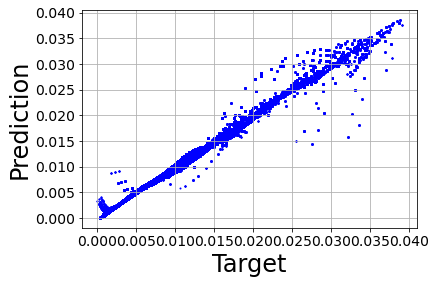

In [21]:
# 500 points
correlation_plot(data_scaled['out'] * scale, y_pred1 * scale, xlabel='Target', ylabel='Prediction')
# plot_for_paper(data_scaled['out'] * scale, y_pred1 * scale, xlabel='Target', ylabel='Prediction', name=f'fullGPR_500.png', save=True)

Root mean squared error is: 0.00026881388624690064


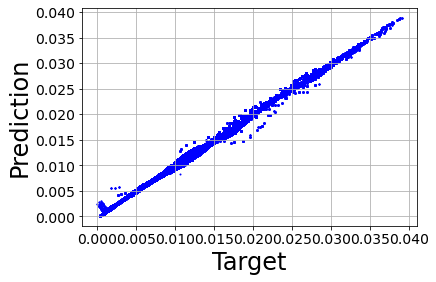

In [22]:
# 2000 points
correlation_plot(data_scaled['out'] * scale, y_pred2 * scale, xlabel='Target', ylabel='Prediction')
# plot_for_paper(data_scaled['out'] * scale, y_pred2 * scale, xlabel='Target', ylabel='Prediction', name=f'fullGPR_2000.png', save=True)

Root mean squared error is: 0.00020460754665725336


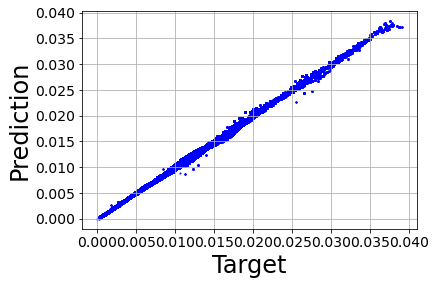

In [23]:
# 5000 points
correlation_plot(data_scaled['out'] * scale, y_pred3 * scale, xlabel='Target', ylabel='Prediction')
# plot_for_paper(data_scaled['out'] * scale, y_pred3 * scale, xlabel='Target', ylabel='Prediction', name=f'fullGPR_5000.png', save=True)

### HDMR FITS

In this example we keep the noise levels fixed for difference levels of the component functions. We only fit the 500 point trainset example due to computational cost.

In [32]:
class RSHDMRGPR:

    def __init__(self, matrices, kernels):
        """
        Initializes an instance of RS-HDMR-GPR object.

        :param matrices: list of 2D numpy.Arrays
            A list of linear transformations.
        :param kernels: a list of Objects from sklearn.guassian_process.kernels
            The kernel to be used for training each HDMR. Right now only RBF and Matern kernels are supported.
        """
        # number of models cannot be empty
        if len(matrices) == 0:
            raise RuntimeError('Must provide at least one component function.')
        if len(matrices) != len(kernels):
            raise RuntimeError(f'Number of affine transformations must be equal to the number of kernels provided'
                               f'which is {len(kernels)}.')

        self.num_rows = matrices[0].shape[0]
        for mat in matrices:
            if mat.shape[0] != self.num_rows:
                raise RuntimeError(f'The rows of the provided matrices are not all the same.')

        self.num_models = len(matrices)
        self.matrices = matrices
        self.kernels = kernels

        self.is_trained = False
        self.models = None
        self.columns = [True] * self.num_models

    @staticmethod
    def verbose_print(msg, end=None, on=True):
        """
        Helper Function used to print messages specified by the user

        :param msg: str
            The message to print
        :param end: str
            Specifies the ending of a line
        :param on: bool
            Specifies whether to print or not
        :return: None
        """
        if on and end is not None:
            print(msg, end=end)
        elif on:
            print(msg)

    def train(self, x_train, y_train, alphas=1e-7, n_restarts=1, cycles=50, scale_down=(0.2, 2), optimizer=None,
              opt_every=5, use_columns=None, initializer='even', report_loss=False, verbose=0, opt_noise=True):
        """
        Trains the RSHDMRGPR model (trains all the GPR sub-models, ie. the component functions).

        :param x_train: pandas DataFrame
            Contains the features.
        :param y_train: list or 1d-array
            The label column of the data.
        :param alphas: float or list of float
            The noise level to be set for the component functions, each of which is a GPR model. If int, the noise
            level for training each of these models is the set to this for all cycles. To set different noise levels for
            different component functions, a list of int must be specified. Note that if optimizer is used, these values
            will be optimized via a WhiteKernel.
        :param scale_down: tuple
            A length 2 tuple containing the starting scale factor and the step size. start represents the starting
            fraction of scale down, and step size represents a rate at which this fraction increases. This is used to
            prevent overfitting of a single component function.
        :param cycles: int
            The number of cycles to train. Must be a positive integer.
        :param optimizer: str or list of str
            Must be a GPR optimizer or list of such. Please see sklearn documentation for GaussianProcessRegressor
            optimizer.
        :param opt_every: int
            Specifies every (opt_every) cycles to apply the optimizer. Default=1 (optimizer applied every cycle). This
            control variable does nothing if the optimizer argument is not provided
        :param use_columns: list of bool or None
            Specifies which column to use (True indicates use, False otherwise). If None (not specified), all columns
            are used.
        :param n_restarts: int
            Positive integer indicating the number of restarts on training. Does nothing meaningful if the optimizer is
            not provided.
        :param initializer: list of float or 'even'
            Initializes the starting targets for each component function. If 'even', every target is initialized as
            y_train / (Number of True in use_columns).
        :param report_loss: bool
            Saves the loss from the prediction on the training set over cycles. Only RMSE (Root mean-squared error) is
            supported for now.
        :param verbose: int
            Sets the various print details option during training. Takes on values 0, 1, or 2. Default is 0.
        :return: Returns 1) if report_rmse = True, 2) otherwise.
            1) self, pandas DataFrame
                The first argument is the trained instance of self. The second contains the RMSE of predicted
                values (vs actual) on the training set for each cycle.
            2) self
                The trained instance of self.
        """

        # Checks if the model has been trained already. Should only train once.
        if self.is_trained:
            raise RuntimeError('Model has already been trained')

        # Validates that the number of features matches the number of rows for each element in self.matrices.
        if x_train.shape[1] != self.num_rows:
            raise RuntimeError(f'Number of columns in provided data which is {x_train.shape[1]} does not match number '
                               f'of rows which is {self.num_rows} in each linear transformation')

        # Validates the noise parameter
        if isinstance(alphas, list):
            if len(alphas) != self.num_models:  # Checks   that number of alphas is equal to the number of models
                raise RuntimeError(f'The length of alphas must match {self.num_models} but received {len(alphas)}')
            for a in alphas:  # Every alpha provided must be an int or float
                if not isinstance(a, (int, float)):
                    raise RuntimeError(f'A non-float value {a} was provided as the noise')
        elif not isinstance(alphas, (int, float)):
            raise RuntimeError('Provided alpha is not a float or list of floats')
        if isinstance(alphas, (int, float)):  # if just a float or int is provided, all noise will be set to this noise
            alphas = [alphas] * self.num_models
        # Adds in the noise parameter (which is WhiteKernel) for each model.
        for i in range(len(self.kernels)):
            self.kernels[i] += WhiteKernel(alphas[i], 'fixed')

        # Validates the scale_down argument
        if scale_down is None:
            start, step = 1, 0  # No scale down in this case
        elif isinstance(scale_down, tuple):
            if len(scale_down) != 2:
                raise RuntimeError(f'scale_down must contain 2 elements but received {len(scale_down)}')
            start, step = scale_down[0], scale_down[1]
        else:
            raise RuntimeError(f'scale_down must be of type {tuple} but received {type(scale_down)}')

        # Validates the optimizer parameter
        if isinstance(optimizer, list):
            if len(optimizer) != self.num_models:
                raise RuntimeError(f'optimizer provided as a list must have length equal to the number of'
                                   f'{self.num_models} but received {len(alphas)}.')
        elif isinstance(optimizer, str):
            optimizer = [optimizer] * self.num_models
        elif optimizer is None:
            optimizer = [optimizer] * self.num_models

        # Decides which component function to use in training
        if use_columns is not None:
            if len(use_columns) == self.num_models and all(isinstance(a, bool) for a in use_columns):
                self.columns = use_columns
            else:
                raise RuntimeError(f"use_columns must be a list of bool of length {self.num_models}.")

        # Initializes the list of models to be trained.
        self.models = [None] * self.num_models

        # Initializes the component outputs used for training.
        if initializer == 'even':
            y_i = [y_train / sum(self.columns)] * self.num_models
            for i in range(self.num_models):
                if not self.columns[i]:
                    y_i[i] = 0
        elif isinstance(initializer, list) and len(initializer) == self.num_models:
            y_i = [initializer[i] * y_train for i in range(self.num_models)]
        else:
            raise RuntimeError(f"Invalid initializer, must be a list of size {self.num_models} or 'even'.")

        # Verbose printing options:
        if verbose not in [0, 1, 2]:
            raise RuntimeError(f'The valid levels of verbose are: 0, 1, or 2, please choose one.')
        else:
            # Sets the verbose levels
            lvl0 = bool(max(0, 1 - verbose))
            lvl1 = bool(max(0, 2 - verbose))
            lvl2 = bool(max(0, 3 - verbose))

        start_time = time.time()
        # These variables are only used if report_rmse is True
        loss_val = []
        cycle_no = []

        self.is_trained = True
        for c in range(cycles):
            self.verbose_print(f'Training iteration for CYCLE {c + 1} has started.', on=lvl1)

            for i in range(self.num_models):

                # Decides which cycle to use optimizer (last cycle will always use)
                opt = optimizer[i] if c % opt_every == 0 or c == cycles - 1 else None

                if c != 0:
                    # Sets the length_scale to the previous round of length_scales
                    self.kernels[i].k1 = self.models[i].kernel_.k1
                    self.kernels[i].k2 = self.models[i].kernel_.k2

                if self.columns[i]:
                    self.verbose_print(f'Training component function: {i + 1}, Optimizer: {opt},', end=" ", on=lvl0)

                    df = np.dot(x_train, self.matrices[i])
                    gpr = GaussianProcessRegressor(kernel=self.kernels[i], optimizer=opt,
                                                   n_restarts_optimizer=n_restarts, alpha=1e-10, random_state=43,
                                                   normalize_y=False)

                    # subtracts every element from y_i except for the i-th variable
                    out_i = y_train - sum(y_i) + y_i[i]
                    gpr.fit(df, out_i)

                    self.verbose_print(f'Resulting length_scale: {gpr.kernel_}', on=lvl0)
                    self.models[i] = gpr  # replaces the gpr model from the previous cycle
                    y_i[i] = gpr.predict(df) * min(start + (1 - start) * step * (c + 1) / cycles, 1)
                else:
                    self.verbose_print(f'Component {i + 1} was omitted from training.', on=lvl1)

            if report_loss:
                # Calculates and records the loss on the training set for each cycle
                predicted = self.predict(x_train)
                loss_val.append(math.sqrt(mean_squared_error(predicted, y_train)))
                cycle_no.append(c + 1)

        self.verbose_print(f'Training completed. Total time for training is {time.time() - start_time:.2f} seconds.',
                           on=lvl2)
        if report_loss:
            return self, pd.DataFrame({'cycle_no': cycle_no, 'rmse': loss_val})
        return self

    def predict(self, test_data, return_std=False):
        """
        Predicts the label using features from test_data.

        :param test_data: DataFrame
            Must have the same number of input features as the data the model was trained on.
        :param return_std: bool
            Returns the standard deviation of the predictions if True.
        :return: 1) return_std=False, 2) otherwise.
            1) numpy.ndarray, numpy.ndarray
                The predicted values and the square-root of the sum of variances.
            2) numpy.ndarray
                The predicted values
        """
        if not self.is_trained:
            raise RuntimeError('This model has not been trained. Train the model before telling it to predict.')

        if return_std:
            y_predict = 0
            y_err_sq = 0
            for i in range(self.num_models):
                if self.columns[i]:
                    df = np.dot(test_data, self.matrices[i])
                    y_pred, y_err = self.models[i].predict(df, return_std=True)
                    y_predict += y_pred
                    y_err_sq += y_err * y_err
            return y_predict, np.sqrt(y_err_sq)
        else:
            y_predict = 0
            for i in range(self.num_models):
                if self.columns[i]:
                    df = np.dot(test_data, self.matrices[i])
                    y_predict += self.models[i].predict(df)
            return y_predict

    def get_models(self):
        """
        Returns the trained component function models.

        :return: list of GaussianProcessRegressor
            The trained hdmr component functions
        """
        if not self.is_trained:
            raise RuntimeError("Model must be trained first before it can be returned.")

        return self.models


def sequential_fitting(x_train, y_train, models, **params):
    """
    This function fits a list of RSHDMRGPR models sequentially. Each model
    is fitted to the difference of the label minus the predictions of the previous
    models.

    :param x_train: pandas DataFrame
        Contains the features.
    :param y_train: list or 1d-array
        The label column of the data.
    :param models: list of RSHDMRGPR models
        Contains the list of RSHDMRGPR models to be fitted sequentially.
    :param params: dict
        variable number of key word arguments.
    :return: None

    """
    n = len(models)
    default = {
        'alphas': [1e-6] * n,  # can be different for each model
        'cycles': 50,
        'scale_down': (0.2, 2),
        'optimizer': 'fmin_l_bfgs_b',
        'opt_every': 5,
        'use_columns': None,
        'n_restarts': 1,
        'initializer': 'even',
        'verbose': 1
    }

    for key in params:
        if key not in default:
            raise RuntimeError(f'{key} is not a hyperparameter.')
        default[key] = params[key]

    print(f"The hyperparameters used are: {default}")
    y = [y_train]
    for i in range(len(models)):
        print(f'\nMODEL {i + 1} with {len(models)} component functions has started training.')
        models[i].train(x_train, y[i], alphas=default['alphas'][i], cycles=default['cycles'],
                        scale_down=default['scale_down'], optimizer=default['optimizer'],
                        opt_every=default['opt_every'], use_columns=default['use_columns'],
                        n_restarts=default['n_restarts'], initializer=default['initializer'],
                        verbose=default['verbose'])
        y_predict = models[i].predict(x_train)
        y.append(y[i] - y_predict)


def sequential_prediction(x_test, models):
    """
    Returns a list of prediction for each order of fit. The i-th element contains the sequential fits up to order i
    (i.e. the sum of the predictions from model[j] for all j = 0, 1, ... , n).

    :param x_test: pandas DataFrame
        The data set to be predicted on.
    :param models: list of RSHDMRGPR models
        Contains the list of RSHDMRGPR models to be fitted sequentially.
    :return: list of 1d-array
        The i-th element contains the sequential fits up to order i (i.e. the sum of the predictions from model[j] for
        all j = 0, 1, ... , n).
    """
    ind_preds = []
    predictions = []
    for i in range(0, len(models)):
        ind_preds.append(batch_predict(models[i], x_test))
        pred = 0
        for j in range(0, i + 1):
            pred += ind_preds[j]
        predictions.append(pred)
    return predictions


def batch_predict(model, data, batch_size=2000, report_size=50000):
    """
    Does batch prediction to conserve memory.

    :param model: Object
        Any machine learning model with a predict method
    :param data: pandas DataFrame
        The dataset to predict on to predict on.
    :param batch_size: int
        Positive integer specifying the size of each batch.
    :param report_size: int
        Used to print a message after predicting on report_size rows of data.
    :return:
    """

    y_predf = []
    i = 0
    while i < data.shape[0]:
        y_pred = model.predict(data.iloc[i: i + batch_size])
        y_predf.extend(y_pred)
        i += batch_size
        if i % report_size == 0:
            print(f'{i} batches have been predicted.')
    return np.array(y_predf)

In [33]:
# Initializes the Model classes for training
matrices1, kernels1 = kernel_matrices(1, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices2, kernels2 = kernel_matrices(2, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices3, kernels3 = kernel_matrices(3, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices4, kernels4 = kernel_matrices(4, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices5, kernels5 = kernel_matrices(5, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices6, kernels6 = kernel_matrices(6, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
matrices7, kernels7 = kernel_matrices(7, 7, length_scale=0.5)#, length_scale_bounds=(0.3, 10000))
hdmr_1d = RSHDMRGPR(matrices1, kernels1)
hdmr_2d = RSHDMRGPR(matrices2, kernels2)
hdmr_3d = RSHDMRGPR(matrices3, kernels3)
hdmr_4d = RSHDMRGPR(matrices4, kernels4)
hdmr_5d = RSHDMRGPR(matrices5, kernels5)
hdmr_6d = RSHDMRGPR(matrices6, kernels6)
hdmr_7d = RSHDMRGPR(matrices7, kernels7)

In [34]:
# models = [hdmr_1d, hdmr_2d, hdmr_3d, hdmr_4d, hdmr_5d,hdmr_6d, hdmr_7d]
hdmr = [hdmr_1d, hdmr_2d, hdmr_3d, hdmr_4d, hdmr_5d, hdmr_6d, hdmr_7d]
alphas = [3 * 1e-3, 8 * 1e-4, 3 * 1e-4, 8 * 1e-5, 3 * 1e-5, 8 * 1e-6, 3 * 1e-6]

In [35]:
sequential_fitting(x_train1, y_train1, hdmr, alphas=alphas, cycles=50, optimizer="fmin_l_bfgs_b", opt_every=5, scale_down=(0.2, 2))

The hyperparameters used are: {'alphas': [0.003, 0.0008, 0.00030000000000000003, 8e-05, 3.0000000000000004e-05, 8e-06, 3e-06], 'cycles': 50, 'scale_down': (0.2, 2), 'optimizer': 'fmin_l_bfgs_b', 'opt_every': 5, 'use_columns': None, 'n_restarts': 1, 'initializer': 'even', 'verbose': 1}

MODEL 1 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.
Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.
Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.
Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has

C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  C

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training completed. Total time for training is 26.87 seconds.

MODEL 2 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 33.78 seconds.

MODEL 3 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 67.84 seconds.

MODEL 4 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 74.37 seconds.

MODEL 5 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 44.23 seconds.

MODEL 6 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.
Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.
Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.
Training iteration for CYCLE 31 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.
Training iteration for CYCLE 36 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anacond

Training completed. Total time for training is 17.59 seconds.

MODEL 7 with 7 component functions has started training.
Training iteration for CYCLE 1 has started.
Training iteration for CYCLE 2 has started.
Training iteration for CYCLE 3 has started.
Training iteration for CYCLE 4 has started.
Training iteration for CYCLE 5 has started.
Training iteration for CYCLE 6 has started.
Training iteration for CYCLE 7 has started.
Training iteration for CYCLE 8 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 9 has started.
Training iteration for CYCLE 10 has started.
Training iteration for CYCLE 11 has started.
Training iteration for CYCLE 12 has started.
Training iteration for CYCLE 13 has started.
Training iteration for CYCLE 14 has started.
Training iteration for CYCLE 15 has started.
Training iteration for CYCLE 16 has started.
Training iteration for CYCLE 17 has started.
Training iteration for CYCLE 18 has started.
Training iteration for CYCLE 19 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 20 has started.
Training iteration for CYCLE 21 has started.
Training iteration for CYCLE 22 has started.
Training iteration for CYCLE 23 has started.
Training iteration for CYCLE 24 has started.
Training iteration for CYCLE 25 has started.
Training iteration for CYCLE 26 has started.
Training iteration for CYCLE 27 has started.
Training iteration for CYCLE 28 has started.
Training iteration for CYCLE 29 has started.
Training iteration for CYCLE 30 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 31 has started.
Training iteration for CYCLE 32 has started.
Training iteration for CYCLE 33 has started.
Training iteration for CYCLE 34 has started.
Training iteration for CYCLE 35 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 36 has started.
Training iteration for CYCLE 37 has started.
Training iteration for CYCLE 38 has started.
Training iteration for CYCLE 39 has started.
Training iteration for CYCLE 40 has started.
Training iteration for CYCLE 41 has started.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Training iteration for CYCLE 42 has started.
Training iteration for CYCLE 43 has started.
Training iteration for CYCLE 44 has started.
Training iteration for CYCLE 45 has started.
Training iteration for CYCLE 46 has started.
Training iteration for CYCLE 47 has started.
Training iteration for CYCLE 48 has started.
Training iteration for CYCLE 49 has started.
Training iteration for CYCLE 50 has started.
Training completed. Total time for training is 2.10 seconds.


C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\owenz\Anaconda3\envs\research\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


In [36]:
preds1 = sequential_prediction(data_scaled.drop(columns=['out']), hdmr)

50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.
50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.
50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predic

In [37]:
i = 1
for p in preds1:
    v = np.corrcoef(p * scale, data_scaled['out'] * scale)[0,1]
    print(f'R^2 for the {i}d-hdmr fit is', v ** 2)
    i += 1

R^2 for the 1d-hdmr fit is 0.9698834906387168
R^2 for the 2d-hdmr fit is 0.9839416325518969
R^2 for the 3d-hdmr fit is 0.989142291720851
R^2 for the 4d-hdmr fit is 0.9959293169694456
R^2 for the 5d-hdmr fit is 0.9959293151390056
R^2 for the 6d-hdmr fit is 0.9910276229307201
R^2 for the 7d-hdmr fit is 0.9910276228985181


The different RMSE's computed are shown below

In [38]:
i = 1
for p in preds1:
    get_RMSE(p * scale, data_scaled['out'] * scale)
    i += 1

The RMSE is 0.001056042589039513
The RMSE is 0.0007746213383160608
The RMSE is 0.0006339877797403306
The RMSE is 0.0003880417483807051
The RMSE is 0.00038804183875787646
The RMSE is 0.0005771383280821848
The RMSE is 0.0005771383278622142


In [39]:
idx = 1
for model in hdmr:
    print(f"Model {idx}'s hyperparameters:")
    print_kernel_info(model.get_models())
    idx += 1

Model 1's hyperparameters:
Component function 1 optimized kernel: RBF(length_scale=0.432) + WhiteKernel(noise_level=0.003)
Component function 2 optimized kernel: RBF(length_scale=0.322) + WhiteKernel(noise_level=0.003)
Component function 3 optimized kernel: RBF(length_scale=3.05) + WhiteKernel(noise_level=0.003)
Component function 4 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.003)
Component function 5 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.003)
Component function 6 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.003)
Component function 7 optimized kernel: RBF(length_scale=0.416) + WhiteKernel(noise_level=0.003)
Model 2's hyperparameters:
Component function 1 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.0008)
Component function 2 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(noise_level=0.0008)
Component function 3 optimized kernel: RBF(length_scale=1e+05) + WhiteKernel(nois